In [658]:
import cv2
import numpy as np
from commonfunctions import *
import imutils

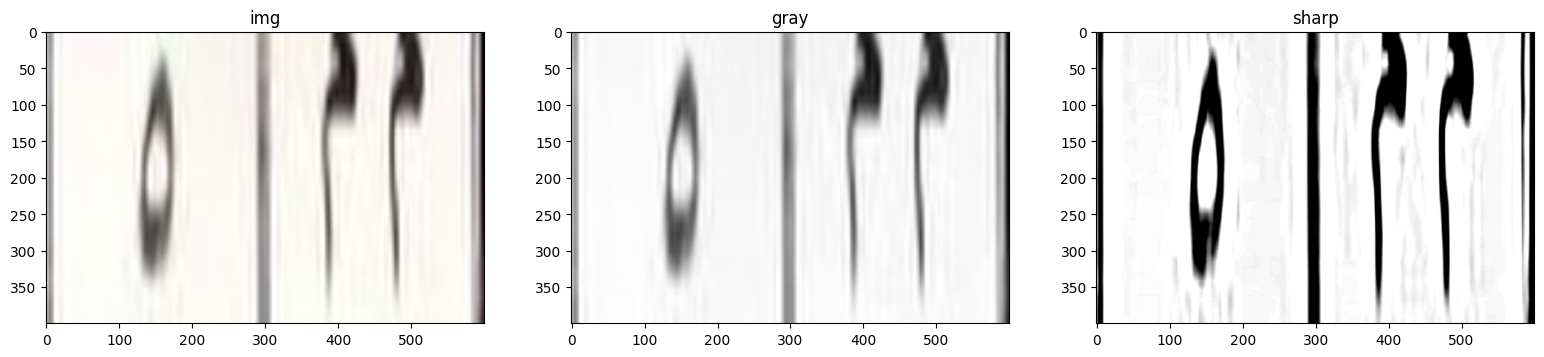

In [659]:
img = cv2.imread('Results3/0079.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (600, 400))
#contrast enhancement
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = cv2.equalizeHist(gray)
# gray = cv2.GaussianBlur(gray, (5, 5), 10)
# gray = np.where(gray < 180, np.min(gray), gray)
sharp = unsharp_mask(gray,10,5)
show_images([img,gray,sharp], ['img','gray','sharp'])


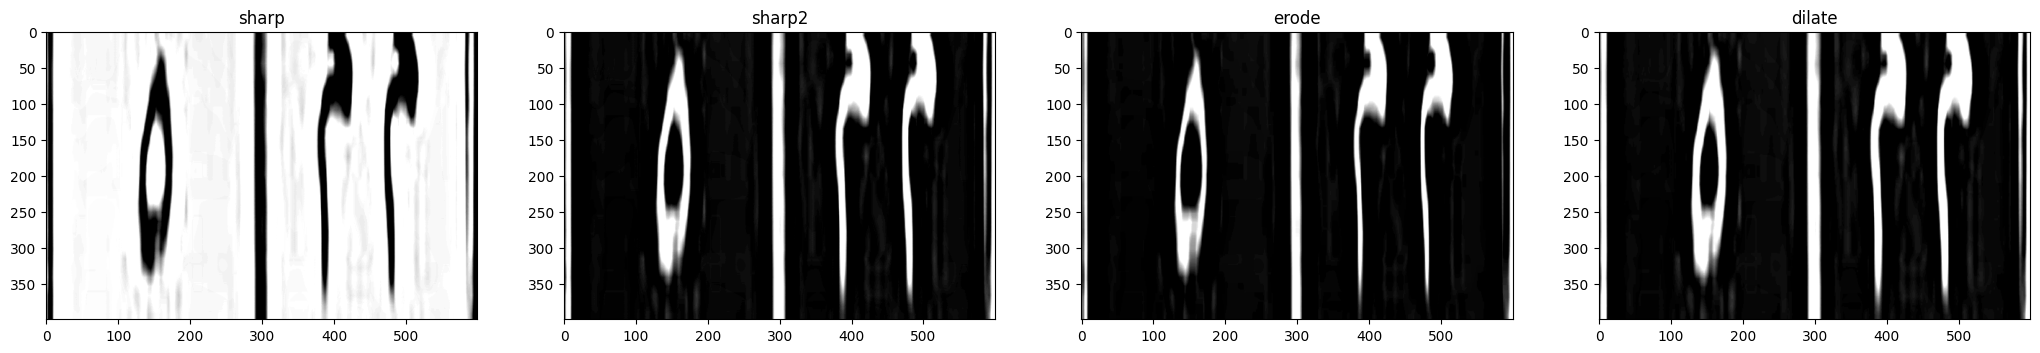

In [660]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 4))
sharp2 = cv2.bitwise_not(sharp)
erode = cv2.erode(sharp, rectKernel, iterations=1)
dilate = cv2.dilate(erode,(3,12), iterations=1)

#max filter
dilate = cv2.bitwise_not(dilate)
erode = cv2.erode(dilate, None, iterations=2)
show_images([sharp,sharp2,erode, dilate], ["sharp","sharp2","erode", "dilate"])

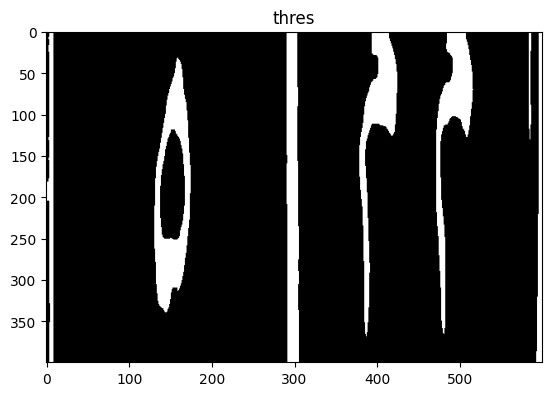

In [661]:
thresh = cv2.threshold(erode, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

show_images([thresh], ["thres"])

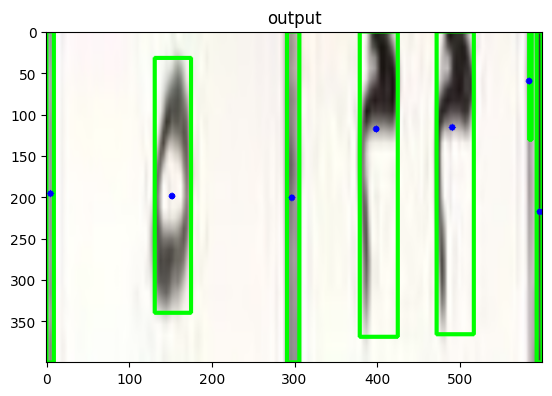

In [662]:
# get connected components and their stats
connectedComponents = cv2.connectedComponentsWithStats(
            thresh, 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = connectedComponents
output = img.copy()

for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
show_images([output], ["output"])

In [663]:
def merge_vertical_rectangles(rectangles):
    merged_rectangles = rectangles.copy()
    for i in range(len(rectangles)):
            if merged_rectangles[i] is not None:
                #get centers
                # find if there is a rectangle just under it
                for j in range(i+1,len(rectangles)):
                    x1,y1,w1,h1 = merged_rectangles[i]
                    if merged_rectangles[j] is not None:
                        x2,y2,w2,h2 = merged_rectangles[j]
                        # get a larger rectangle that contains both
                        if (x1 <= x2 and x1+w1 >= x2) or (x1 >= x2 and x1 <= x2+w2):
                        
                            # merge the two rectangles
                            x1_new = min(x1,x2)
                            y1_new = min(y1,y2)
                            x2_new = max(x1+w1,x2+w2)
                            y2_new = max(y1+h1,y2+h2)
                            w_new = x2_new-x1_new
                            h_new = y2_new-y1_new
                            new_rect = (x1_new,y1_new,w_new,h_new)
                            new_aspect_ratio = w_new/h_new
                            if new_aspect_ratio < 0.6:
                                merged_rectangles[i] = new_rect
                                merged_rectangles[j] = None
    return merged_rectangles
    

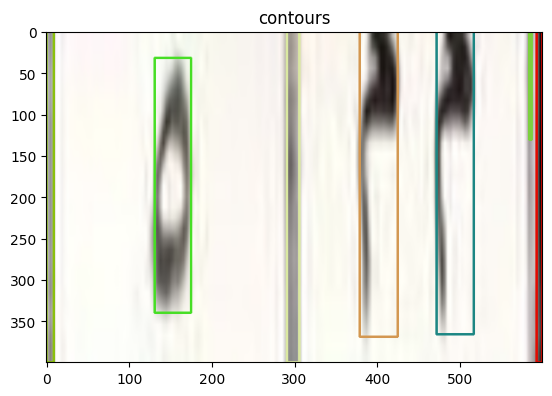

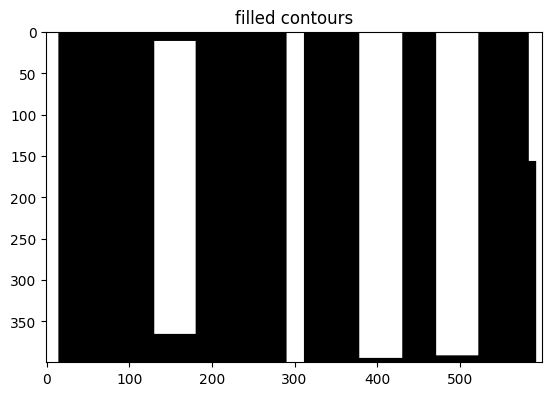

0.14124293785310735 17700
0.04 6400
0.13010204081632654 19992
0.13164556962025317 20540
0.0525 8400
0.0375 6000


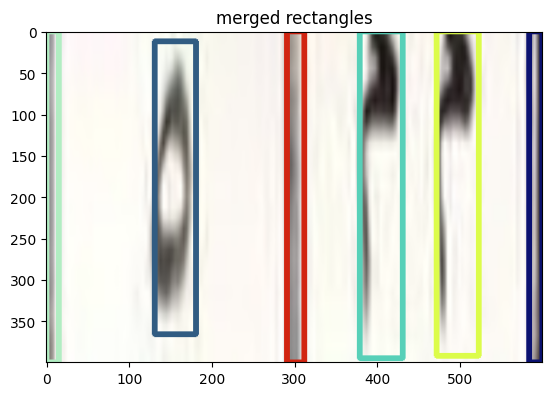

In [664]:
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
img_copy = img.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    # random color
    color = np.random.randint(0, 255, size=(3,)).tolist()
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 2)
show_images([img_copy], ['contours'])
    
img_filled = np.zeros_like(img)
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    aspect_ratio = w/h
    area = w*h
    if 0 < aspect_ratio < 1.4 and area < 50000:
        cv2.rectangle(img_filled, (x,y), (x+w,y+h), (255,255,255), thickness=cv2.FILLED)
img_filled = cv2.morphologyEx(img_filled, cv2.MORPH_DILATE,
                              cv2.getStructuringElement(cv2.MORPH_RECT, (2,10)),iterations=5)
img_filled = cv2.cvtColor(img_filled, cv2.COLOR_BGR2GRAY)
show_images([img_filled], ['filled contours'])

# find contours of filled image
cnts2 = cv2.findContours(img_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts2 = imutils.grab_contours(cnts2)
rectangles = []
for c in cnts2:
    (x, y, w, h) = cv2.boundingRect(c)
    rectangles.append((x,y,w,h))
# rectangles = merge_vertical_rectangles(rectangles)

img_copy = img.copy()
image_area = img.shape[0]*img.shape[1]
img_width = img.shape[1]
for r in rectangles:
    if r is not None:
        (x, y, w, h) = r
        # random color
        aspect_ratio = w/h
        area = w*h
        print(aspect_ratio,area)
        if w < 0.6*h and 1500 < area < image_area/5 and  img_width/50< w:
            color = np.random.randint(0, 255, size=(3,)).tolist()
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 5)
show_images([img_copy], ['merged rectangles'])

In [665]:
from imutils.contours import sort_contours